In [1]:
import torch
from torch import nn
from collections import namedtuple
import sys
import os
import matplotlib.pyplot as plt
import numpy as np

BASE_DIR = os.path.dirname(os.path.realpath(os.getcwd()))
sys.path.append(BASE_DIR)

import utils

In [2]:
from robustness.datasets import CIFAR
from robustness.model_utils import make_and_restore_model

ds = CIFAR('~/datasets/cifar10/')

resnet, _ = make_and_restore_model(arch='resnet50', dataset=ds,
                                   resume_path='cifar_linf_8.pt')
resnet = resnet.module
resnet.eval()
resnet.cuda()
None

=> loading checkpoint 'cifar_linf_8.pt'
=> loaded checkpoint 'cifar_linf_8.pt' (epoch 153)


In [5]:
resnet.model = 

robustness.cifar_models.resnet.ResNet

In [3]:
from models.dist_model import DistModel
import torch.nn.functional as F

ResNetOutputs = namedtuple('ResNetOutputs', ['layer1', 'layer2', 'layer3', 'layer4'])

class AdvResNetModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.normalizer = model.normalizer
        self.model = model.model

    def forward(self, x):
        x = self.normalizer(x)
        
        x = F.relu(self.model.bn1(self.model.conv1(x)))

        x = self.model.layer1(x)
        x_layer1 = x
        x = self.model.layer2(x)
        x_layer2 = x
        x = self.model.layer3(x)
        x_layer3 = x
        x = self.model.layer4(x, fake_relu=False)
        x_layer4 = x

        x = F.avg_pool2d(x, 4)
        pre_out = x.view(x.size(0), -1)
        final = self.model.linear(pre_out)
        
        return ResNetOutputs(x_layer1, x_layer2, x_layer3, x_layer4), final

net = AdvResNetModel(resnet)
[h.size() for h in net(torch.zeros((10, 3, 32, 32)).cuda())[0]]

[torch.Size([10, 256, 32, 32]),
 torch.Size([10, 512, 16, 16]),
 torch.Size([10, 1024, 8, 8]),
 torch.Size([10, 2048, 4, 4])]

In [4]:
def normalize_flatten_activations(acts, eps=1e-10):
    normalized_acts = []
    for act in acts:
        norm_factor = torch.sqrt(torch.sum(act ** 2, dim=1, keepdim=True))
        normalized_acts.append(
            (act / (act.size()[1] * act.size()[2] * act.size()[3]))
            .reshape(act.size()[0], -1)
        )
    return torch.cat(normalized_acts, dim=1)

normalize_flatten_activations(net(torch.zeros((10, 3, 32, 32)).cuda())[0])

tensor([[6.5841e-07, 8.1001e-07, 9.2297e-07,  ..., 0.0000e+00, 4.5015e-07,
         0.0000e+00],
        [6.5841e-07, 8.1001e-07, 9.2297e-07,  ..., 0.0000e+00, 4.5015e-07,
         0.0000e+00],
        [6.5841e-07, 8.1001e-07, 9.2297e-07,  ..., 0.0000e+00, 4.5015e-07,
         0.0000e+00],
        ...,
        [6.5841e-07, 8.1001e-07, 9.2297e-07,  ..., 0.0000e+00, 4.5015e-07,
         0.0000e+00],
        [6.5841e-07, 8.1001e-07, 9.2297e-07,  ..., 0.0000e+00, 4.5015e-07,
         0.0000e+00],
        [6.5841e-07, 8.1001e-07, 9.2297e-07,  ..., 0.0000e+00, 4.5015e-07,
         0.0000e+00]], device='cuda:0', grad_fn=<CatBackward>)

In [5]:
%matplotlib inline
def show(img):
    if len(img.size()) == 4:
        img = torchvision.utils.make_grid(img, nrow=10, padding=0)
    npimg = img.detach().cpu().numpy()
    plt.figure(figsize=(18,16), dpi=80, facecolor='w', edgecolor='k')
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [14]:
import torchvision
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

val_dataset = CIFAR10(
    '~/datasets/cifar10',
    train=False,
    transform=torchvision.transforms.ToTensor(),
)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=True)
inputs, labels = next(iter(val_loader))
inputs = inputs.cuda()
labels = labels.cuda()

tensor([True, True, True, True, True, True, True, True, True, True],
       device='cuda:0')
tensor([True, True, True, True, True, True, True, True, True, True],
       device='cuda:0')


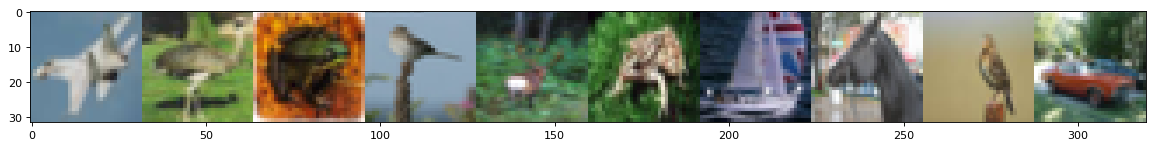

In [15]:
show(inputs)
print(resnet(inputs)[0].argmax(1) == labels)
print(net(inputs)[1].argmax(1) == labels)

In [8]:
eps = 1e-4
outer_iters = 100
outer_step_size = 1e-5
inner_iters = 10
inner_lr = 10

perturbations = torch.zeros_like(inputs)
perturbations.requires_grad = True
orig_acts = normalize_flatten_activations(net(inputs)[0])

optim = torch.optim.SGD([perturbations], lr=inner_lr)

for _ in range(outer_iters):
    adv_inputs = inputs + perturbations

    adv_acts, adv_logits = net(adv_inputs)
    print('accuracy =', (adv_logits.argmax(1) == labels).float().mean().cpu().detach().item())
    for act in adv_acts:
        act.retain_grad()
    adv_loss = utils.calculate_base_loss(adv_logits, labels)
    adv_loss.sum().backward(retain_graph=True)
        
    act_grads = normalize_flatten_activations([act.grad for act in adv_acts])
    act_grads = utils.normalize(act_grads, 2)
    adv_acts = normalize_flatten_activations(adv_acts)
    
    act_perturbations = adv_acts - orig_acts
    print('act_perturbations.norm =', act_perturbations.norm(dim=1))
    act_perturbations = act_perturbations + act_grads * outer_step_size
    act_perturbations = act_perturbations.renorm(p=2, dim=0, maxnorm=eps)
    
    target_acts = (orig_acts + act_perturbations).detach()
        
    for _ in range(inner_iters):
        optim.zero_grad()
        adv_inputs = inputs + perturbations
        
        adv_acts, _ = net(adv_inputs)
        adv_acts = normalize_flatten_activations(adv_acts)
        act_distance = (adv_acts - target_acts).norm(p=2, dim=1)
        #print('act_distance =', act_distance)
        act_distance.sum().backward()
        optim.step()
        
        perturbations.data = perturbations.data.clamp(0, 1)

accuracy = 0.9000000357627869
act_perturbations.norm = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       grad_fn=<NormBackward3>)
accuracy = 0.9000000357627869
act_perturbations.norm = tensor([2.7654e-05, 9.0048e-05, 2.6584e-05, 4.7150e-05, 9.3015e-05, 1.3456e-04,
        2.8633e-05, 4.3701e-05, 3.4427e-04, 8.4125e-05], device='cuda:0',
       grad_fn=<NormBackward3>)
accuracy = 0.9000000357627869
act_perturbations.norm = tensor([4.8638e-05, 1.2734e-04, 4.1159e-05, 7.6719e-05, 2.7140e-04, 2.0433e-04,
        4.5381e-05, 7.5120e-05, 7.6099e-05, 7.2107e-05], device='cuda:0',
       grad_fn=<NormBackward3>)
accuracy = 0.9000000357627869
act_perturbations.norm = tensor([6.5083e-05, 1.4670e-04, 5.1694e-05, 9.0122e-05, 2.2635e-04, 1.8356e-04,
        6.0123e-05, 1.0135e-04, 1.1420e-04, 1.1416e-04], device='cuda:0',
       grad_fn=<NormBackward3>)
accuracy = 0.9000000357627869
act_perturbations.norm = tensor([7.7005e-05, 1.3730e-04, 6.1283e-05, 1.0808e-04, 2.1441e-04, 2

accuracy = 0.9000000357627869
act_perturbations.norm = tensor([1.0422e-04, 1.4530e-04, 1.1017e-04, 9.3596e-05, 1.5334e-04, 1.3790e-04,
        1.0682e-04, 1.1765e-04, 1.0726e-04, 1.0731e-04], device='cuda:0',
       grad_fn=<NormBackward3>)
accuracy = 0.9000000357627869
act_perturbations.norm = tensor([1.0326e-04, 1.1201e-04, 1.1117e-04, 9.6202e-05, 1.5299e-04, 1.5970e-04,
        1.0788e-04, 1.0823e-04, 1.0872e-04, 1.1085e-04], device='cuda:0',
       grad_fn=<NormBackward3>)
accuracy = 0.9000000357627869
act_perturbations.norm = tensor([1.0820e-04, 1.2915e-04, 1.0484e-04, 9.8719e-05, 1.5160e-04, 1.4224e-04,
        1.0968e-04, 1.1384e-04, 1.1390e-04, 1.1305e-04], device='cuda:0',
       grad_fn=<NormBackward3>)
accuracy = 0.9000000357627869
act_perturbations.norm = tensor([0.0001, 0.0001, 0.0001, 0.0001, 0.0002, 0.0002, 0.0001, 0.0001, 0.0001,
        0.0001], device='cuda:0', grad_fn=<NormBackward3>)
accuracy = 0.9000000357627869
act_perturbations.norm = tensor([0.0001, 0.0001, 0.00

accuracy = 0.9000000357627869
act_perturbations.norm = tensor([0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
        0.0001], device='cuda:0', grad_fn=<NormBackward3>)
accuracy = 0.9000000357627869
act_perturbations.norm = tensor([0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
        0.0001], device='cuda:0', grad_fn=<NormBackward3>)
accuracy = 0.9000000357627869
act_perturbations.norm = tensor([0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
        0.0001], device='cuda:0', grad_fn=<NormBackward3>)
accuracy = 0.9000000357627869
act_perturbations.norm = tensor([0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
        0.0001], device='cuda:0', grad_fn=<NormBackward3>)
accuracy = 0.9000000357627869
act_perturbations.norm = tensor([0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
        0.0001], device='cuda:0', grad_fn=<NormBackward3>)
accuracy = 0.9000000357627869


In [16]:
lam = 1e3

iters = 100
lr = 0.1

perturbations = torch.zeros_like(inputs)
perturbations.requires_grad = True
orig_acts = normalize_flatten_activations(net(inputs)[0][0:1]).detach()

optim = torch.optim.SGD([perturbations], lr=lr)

for attack_iter in range(iters):
    optim.param_groups[0]['lr'] = lr * (0.1 ** (attack_iter / iters))
    optim.zero_grad()
    adv_inputs = inputs + perturbations

    adv_acts, adv_logits = net(adv_inputs)
    adv_acts = normalize_flatten_activations(adv_acts[0:1])
    
    adv_loss = utils.calculate_base_loss(adv_logits, labels)
    adv_loss = -torch.abs(-adv_loss + 5)
    act_dist = (adv_acts - orig_acts).norm(p=2, dim=1)
    #print('act_dist =', act_dist)
    
    loss = -adv_loss + (lam * act_dist) * 2
    loss.sum().backward()
    optim.step()
    
    print('accuracy = {:.1f}%, adv_loss = {:.2f}, act_dist = {:.1f}'.format(
        (adv_logits.argmax(1) == labels).float().mean().cpu().detach().item() * 100,
        adv_loss.sum().cpu().detach().item(),
        (lam * act_dist).mean().cpu().detach().item(),
    ))
        
    perturbations.data = perturbations.data.clamp(0, 1)

accuracy = 100.0%, adv_loss = -71.56, act_dist = 0.0
accuracy = 100.0%, adv_loss = -65.12, act_dist = 0.0
accuracy = 80.0%, adv_loss = -60.21, act_dist = 0.0
accuracy = 60.0%, adv_loss = -56.34, act_dist = 0.0
accuracy = 60.0%, adv_loss = -52.81, act_dist = 0.0
accuracy = 40.0%, adv_loss = -47.93, act_dist = 0.0
accuracy = 40.0%, adv_loss = -44.40, act_dist = 0.0
accuracy = 40.0%, adv_loss = -41.17, act_dist = 0.1
accuracy = 40.0%, adv_loss = -37.19, act_dist = 0.1
accuracy = 30.0%, adv_loss = -34.33, act_dist = 0.1
accuracy = 30.0%, adv_loss = -33.50, act_dist = 0.1
accuracy = 30.0%, adv_loss = -29.95, act_dist = 0.1
accuracy = 30.0%, adv_loss = -29.52, act_dist = 0.1
accuracy = 30.0%, adv_loss = -26.91, act_dist = 0.1
accuracy = 30.0%, adv_loss = -27.24, act_dist = 0.1
accuracy = 10.0%, adv_loss = -26.74, act_dist = 0.1
accuracy = 10.0%, adv_loss = -26.21, act_dist = 0.1
accuracy = 10.0%, adv_loss = -25.12, act_dist = 0.1
accuracy = 10.0%, adv_loss = -25.21, act_dist = 0.1
accuracy =

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([True, True, True, True, True, True, True, True, True, True],
       device='cuda:0')


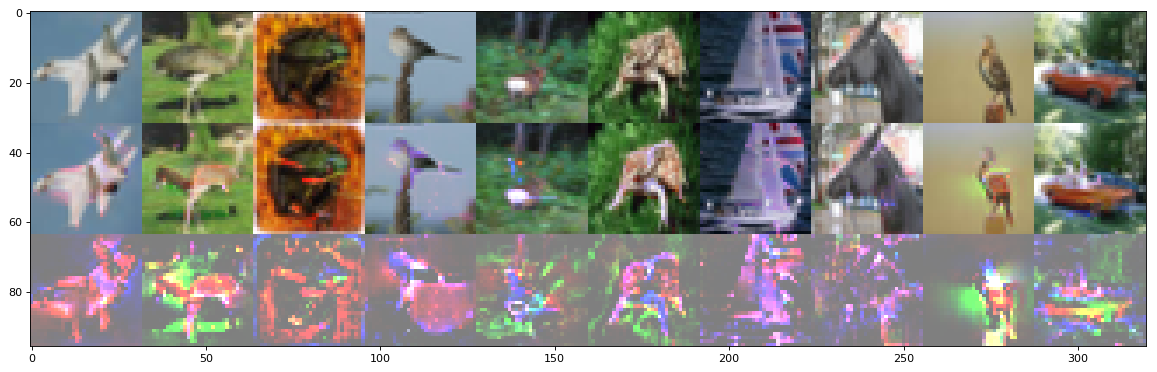

In [17]:
orig_labels = net(inputs)[1].argmax(1)
adv_labels = net(inputs + perturbations)[1].argmax(1)
#perturbations[adv_labels == labels, :] = 0
success = (orig_labels == labels) & (adv_labels != labels)
print(success)
show(torch.cat([inputs, inputs + perturbations, perturbations * 5 + 0.5]))